In [29]:
# 모듈 로딩
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [30]:
# 가중치 고정
tf.random.set_seed(42)
np.random.seed(42)

In [31]:
# 데이터 가져오기
(X_train, y_train), (X_test, y_label) = tf.keras.datasets.mnist.load_data()

In [32]:
# 데이터 전처리
X_train=X_train.reshape(-1, 28, 28, 1).astype('float64')
X_train=(X_train-127.5)/127.5

X_test=X_test.reshape(-1, 28, 28, 1).astype('float64')
X_test=(X_test-127.5)/127.5
# 마지막 layer의 활성화 함수로 sigmoid(0~1) 보다 tanh(-1~1)를 더 선호합니다.

In [33]:
X_train.shape

(60000, 28, 28, 1)

In [34]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
train_dataset=tf.data.Dataset.from_tensor_slices(X_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [35]:
# Vanila GAN
# Generator 모델 작성
# G 모델은 Noise로 부터 원래의 데이터를 생성해내는 모델입니다.
# Input : 100차원의 noise
# Output : Mnist 이미지 크기인 28*28

inputs=keras.Input(shape=(100,))
x=inputs
x=layers.Dense(256)(x)
x=layers.LeakyReLU()(x)
x=layers.Dense(28*28, activation='tanh')(x)
outputs=layers.Reshape((28,28))(x)

In [36]:
G=keras.Model(inputs, outputs)

In [37]:
G.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_12 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 784)               201488    
                                                                 
 reshape_5 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 227,344
Trainable params: 227,344
Non-trainable params: 0
_________________________________________________________________


In [39]:
plot_model(G)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [40]:
# Discriminaotr 모델 작성
# D모델은 28*28 이미지가 실제 데이터인지 만들어진 데이터인지 판별합니다.
# Input : Mnist 이미지 (28*28)
# Output : 실제 데이터 일 확률 (0~1 사이의 값)
inputs = keras.Input(shape=(28,28))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1)(x)

In [41]:
D = keras.Model(inputs, outputs)
D.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 256)               200960    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 201,217
Trainable params: 201,217
Non-trainab

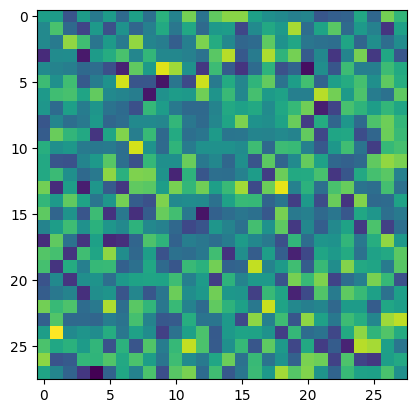

In [42]:
# 임의의 Noise를 G모델에 통과시키면 28*28 사이즈의 랜덤 이미지가 만들어집니다.
test_noise=tf.random.normal([1,100])
fake_image_test=G(test_noise, training=False)

plt.imshow(fake_image_test[0])

In [43]:
# 그리고 G모델에서 만들어진 이미지를 D모델에 통과시키면 확률이 나오게 됩니다.
decision = D(fake_image_test, training=False)
print(decision)

tf.Tensor([[-0.3954052]], shape=(1, 1), dtype=float32)


In [44]:
# GAN 훈련 구현
# G모델, D모델을 훈련시킬 Loss를 생성해줍니다.
# G모델과 D모델을 순서대로 훈련시키는 과정을 반복합니다.

In [45]:
EPOCHS = 50
noise_dim = 100

seed = tf.random.normal([BATCH_SIZE, noise_dim])

G_optimizer = tf.keras.optimizers.Adam(1e-4)
D_optimizer = tf.keras.optimizers.Adam(1e-4)

In [46]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def D_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def G_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)